Ecommerce Data

In [72]:
import pandas as pd

In [73]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA6505_Fall_2024/ecommerce_data.csv', encoding='unicode_escape')
df.dropna(inplace=True)
len(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


406829

In [74]:
df = df[df['Description'].str.match(r'^[A-Z0-9 ]+$', na=False)]  # Only capital letters and numbers, no question marks or lowercase letters
# Step 2: Clean StockCode
# Keep only alphanumeric and numeric codes with 6 or fewer characters
df = df[df['StockCode'].str.match(r'^[A-Za-z0-9]{1,6}$', na=False)]  # Only alphanumeric codes of length 6 or less
# Display the number of rows after cleaning
print(f"Number of rows after cleaning: {df.shape[0]}")

Number of rows after cleaning: 363801


In [75]:
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [76]:
# Check for negative values in 'Quantity' and 'UnitPrice'
negative_quantities = df[df['Quantity'] < 0]
negative_unit_prices = df[df['UnitPrice'] < 0]
# Display the results
print(f"Rows with negative quantities:\n{negative_quantities}")
print(f"Rows with negative unit prices:\n{negative_unit_prices}")
# Optionally, check the count of such rows
print(f"Number of rows with negative quantities: {negative_quantities.shape[0]}")
print(f"Number of rows with negative unit prices: {negative_unit_prices.shape[0]}")

Rows with negative quantities:
Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []
Rows with negative unit prices:
Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []
Number of rows with negative quantities: 0
Number of rows with negative unit prices: 0


In [77]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom


In [78]:
df['Date']= pd.to_datetime(df['InvoiceDate'])



In [79]:
most_recent_date = df['Date'].max()

# Calculate recency as the absolute number of days since the most recent transaction
df['recency'] = (most_recent_date - df['Date']).dt.days

# Group by CustomerID to find the minimum recency (most recent transaction) for each customer
df_rec = df.groupby('CustomerID', as_index=False)['recency'].min()



In [80]:
df_rec.head()

,CustomerID,recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [81]:
df_freq = df.groupby('CustomerID', as_index=False).size().rename(columns={'size': 'frequency'})

In [82]:
df_freq.head()

,CustomerID,frequency
0,12346.0,1
1,12347.0,174
2,12348.0,31
3,12349.0,66
4,12350.0,16


In [83]:
df['monetary_value'] = df['Quantity'] * df['UnitPrice']

# Group by CustomerID and sum the monetary value for each customer
df_monetary = df.groupby('CustomerID', as_index=False)['monetary_value'].sum()

# Rename the monetary value column to something more descriptive
df_monetary.rename(columns={'monetary_value': 'total_spent'}, inplace=True)

In [84]:
df_final = pd.merge(df_rec, df_freq, on='CustomerID', how='inner')
df_final = pd.merge(df_final, df_mon, on='CustomerID', how='inner')

# Rename the monetary column for clarity
df_final.rename(columns={'monetary': 'monetary_value'}, inplace=True)

# Display the final DataFrame
df_final

,CustomerID,recency,frequency,monetary_value
0,12346.0,325,1,77183.60
1,12347.0,1,174,4169.45
2,12348.0,74,31,1797.24
3,12349.0,18,66,1626.25
4,12350.0,309,16,316.70
...,...,...,...,...
4312,18280.0,277,10,180.60
4313,18281.0,180,7,80.82
4314,18282.0,7,12,178.05
4315,18283.0,3,685,1780.16


recency:


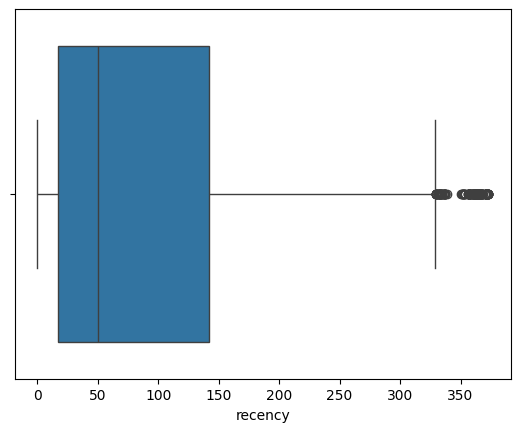

frequency:


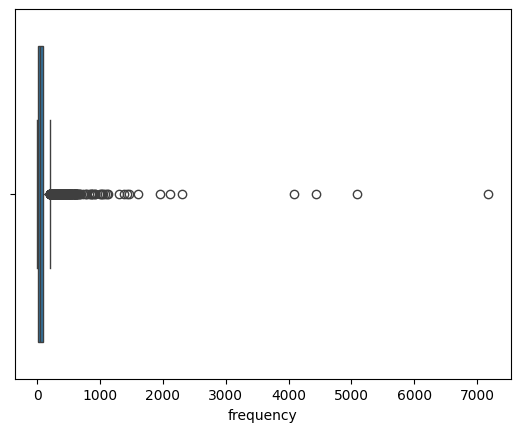

monetary_value:


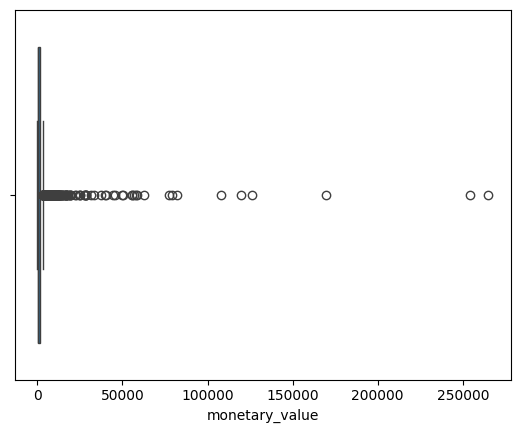

,CustomerID,recency,frequency,monetary_value


In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of columns to check for outliers
list1 = ['recency', 'frequency', 'monetary_value']

# Visualize boxplots for each column
for i in list1:
    print(f"{i}:")
    ax = sns.boxplot(x=df_final[i])
    plt.show()

# Remove outliers based on the IQR method
Q1 = df_final[list1].quantile(0.25)
Q3 = df_final[list1].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df_final_no_outliers = df_final[
    (df_final[list1] >= lower_bound) & (df_final[list1] <= upper_bound)
].dropna()

# Display the DataFrame without outliers
df_final_no_outliers

In [88]:
from scipy import stats
import numpy as np

# Remove the CustomerID column and focus on the relevant columns
new_df = df_final[['recency', 'frequency', 'monetary_value']]

# Calculate Z-scores for the relevant columns
z_scores = stats.zscore(new_df)

# Get the absolute Z-scores
abs_z_scores = np.abs(z_scores)

# Filter entries where all Z-scores are below 3 (no outliers)
filtered_entries = (abs_z_scores < 3).all(axis=1)

# Create the new DataFrame without outliers
new_df = new_df[filtered_entries]

# Display the cleaned DataFrame
new_df

,recency,frequency,monetary_value
1,1,174,4169.45
2,74,31,1797.24
3,18,66,1626.25
4,309,16,316.70
5,35,80,1634.04
...,...,...,...
4312,277,10,180.60
4313,180,7,80.82
4314,7,12,178.05
4315,3,685,1780.16


In [90]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the relevant columns
columns_to_standardize = ['recency', 'frequency', 'monetary_value']
new_df[columns_to_standardize] = scaler.fit_transform(new_df[columns_to_standardize])

# Display the standardized DataFrame
new_df

,recency,frequency,monetary_value
1,-0.912902,1.117240,1.378877
2,-0.185329,-0.426677,0.244263
3,-0.743467,-0.048795,0.162480
4,2.156861,-0.588626,-0.463870
5,-0.574032,0.102358,0.166206
...,...,...,...
4312,1.837925,-0.653406,-0.528966
4313,0.871149,-0.685795,-0.576690
4314,-0.853102,-0.631812,-0.530185
4315,-0.892969,6.634315,0.236094


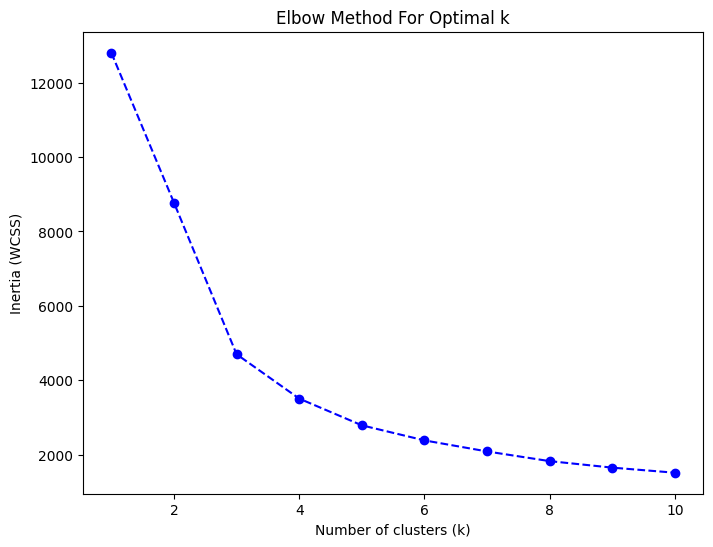

In [91]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Initialize a list to store the inertia values
inertia = []

# Try K-values from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(new_df)  # Fit KMeans on the standardized data
    inertia.append(kmeans.inertia_)  # Append the inertia value for this k

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--', color='b')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.show()

In [92]:
kmeans = KMeans( n_clusters = 4, init='k-means++')
kmeans.fit(scaled_features)

KMeans(n_clusters=4)

In [96]:
from sklearn.cluster import KMeans

# Set the optimal number of clusters based on the elbow method
optimal_k = 4  # Replace with the elbow point you determined

# Fit the KMeans model
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
new_df['cluster'] = kmeans.fit_predict(new_df)

# Display the first 5 rows with the assigned cluster labels
new_df.head()

,recency,frequency,monetary_value,cluster
1,-0.912902,1.117240,1.378877,2
2,-0.185329,-0.426677,0.244263,1
3,-0.743467,-0.048795,0.162480,1
4,2.156861,-0.588626,-0.463870,0
5,-0.574032,0.102358,0.166206,1


In [103]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(new_df[['recency', 'frequency']])

In [105]:
kmeans_rf = KMeans(n_clusters=optimal_k, random_state=42)
new_df['rf_cluster'] = kmeans_rf.fit_predict(scaled_features)

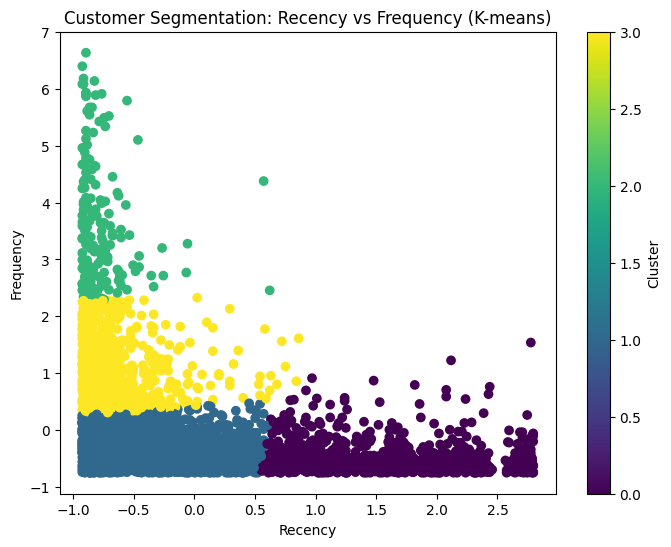

In [106]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Select only Recency and Frequency columns
recency_frequency_df = new_df[['recency', 'frequency']]

# Set the optimal number of clusters (this can be based on the elbow method, e.g., optimal_k = 4)
optimal_k = 4  # Replace with the elbow point you determined

# Fit the KMeans model
kmeans_rf = KMeans(n_clusters=optimal_k, random_state=42)
new_df['rf_cluster'] = kmeans_rf.fit_predict(recency_frequency_df)

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(new_df['recency'], new_df['frequency'], c=new_df['rf_cluster'], cmap='viridis')
plt.title('Customer Segmentation: Recency vs Frequency (K-means)')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.colorbar(label='Cluster')
plt.show()

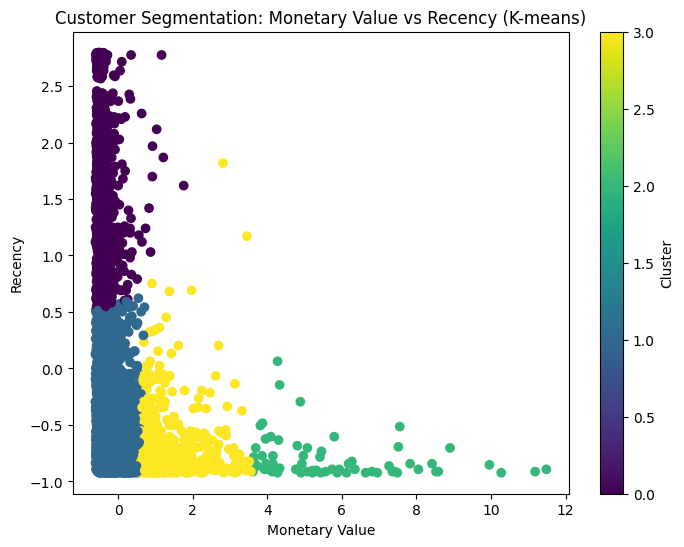

In [99]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Select only Monetary Value and Recency columns
monetary_recency_df = new_df[['monetary_value', 'recency']]

# Set the optimal number of clusters (this can be based on the elbow method, e.g., optimal_k = 4)
optimal_k = 4  # Replace with the elbow point you determined

# Fit the KMeans model
kmeans_mr = KMeans(n_clusters=optimal_k, random_state=42)
new_df['mr_cluster'] = kmeans_mr.fit_predict(monetary_recency_df)

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(new_df['monetary_value'], new_df['recency'], c=new_df['mr_cluster'], cmap='viridis')
plt.title('Customer Segmentation: Monetary Value vs Recency (K-means)')
plt.xlabel('Monetary Value')
plt.ylabel('Recency')
plt.colorbar(label='Cluster')
plt.show()

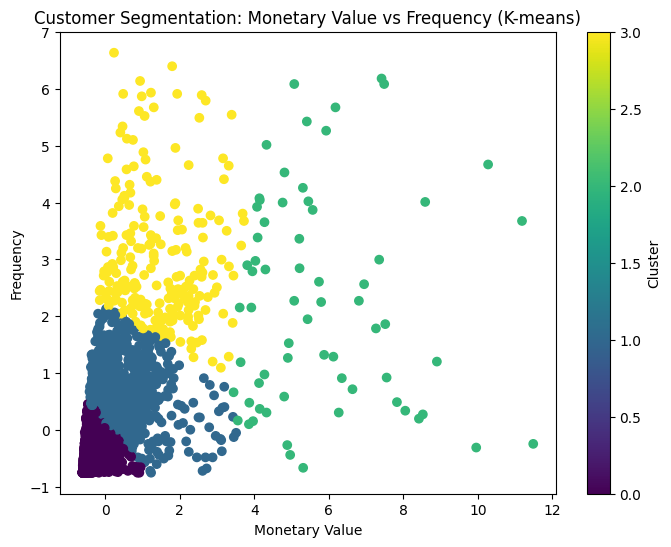

In [107]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Select the Monetary Value and Frequency columns
monetary_frequency_df = new_df[['monetary_value', 'frequency']]

# Step 2: Standardize the features
scaler = StandardScaler()
scaled_monetary_frequency = scaler.fit_transform(monetary_frequency_df)

# Step 3: Set the optimal number of clusters (e.g., 4 clusters)
optimal_k = 4  # Replace with the elbow point you determined
kmeans_mf = KMeans(n_clusters=optimal_k, random_state=42)

# Step 4: Fit the K-means model and predict clusters
new_df['mf_cluster'] = kmeans_mf.fit_predict(scaled_monetary_frequency)

# Step 5: Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(new_df['monetary_value'], new_df['frequency'], c=new_df['mf_cluster'], cmap='viridis')
plt.title('Customer Segmentation: Monetary Value vs Frequency (K-means)')
plt.xlabel('Monetary Value')
plt.ylabel('Frequency')
plt.colorbar(label='Cluster')
plt.show()

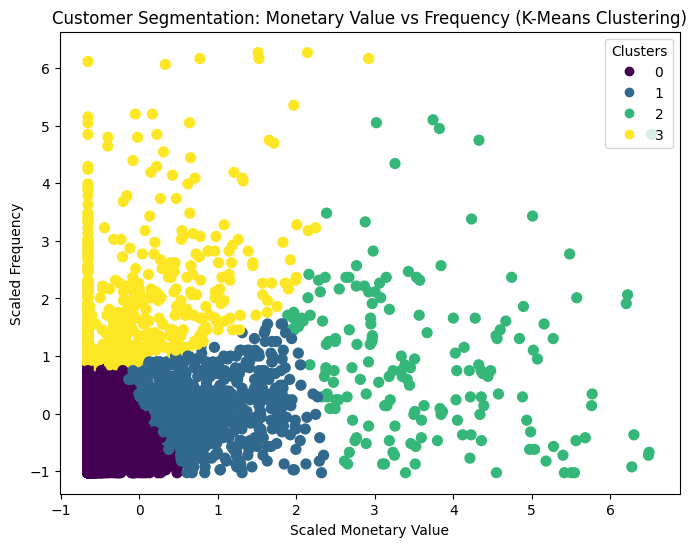

In [71]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select the relevant features for clustering: 'monetary_value' and 'frequency'
features = new_df[['monetary_value', 'frequency']]

# Scale the features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform K-Means with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
new_df['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the clusters
plt.figure(figsize=(8, 6))

# Plot each cluster with a different color
scatter = plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=new_df['cluster'], cmap='viridis', s=50)

# Add labels and title
plt.title('Customer Segmentation: Monetary Value vs Frequency (K-Means Clustering)')
plt.xlabel('Scaled Monetary Value')
plt.ylabel('Scaled Frequency')

# Add a legend
plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")

# Show the plot
plt.show()


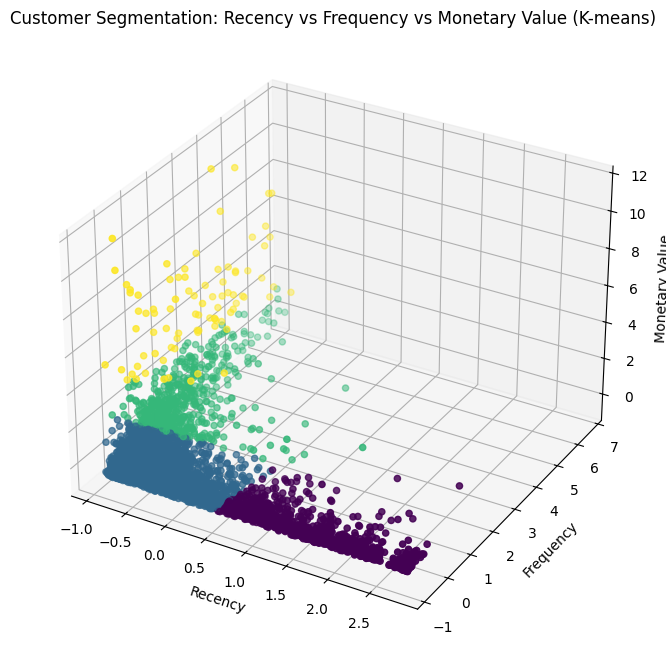

In [108]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Select Recency, Frequency, and Monetary Value columns
three_features_df = new_df[['recency', 'frequency', 'monetary_value']]

# Step 2: Standardize the features
scaler = StandardScaler()
scaled_three_features = scaler.fit_transform(three_features_df)

# Step 3: Set the optimal number of clusters (e.g., 4 clusters)
optimal_k = 4  # Replace with the elbow point you determined
kmeans_3d = KMeans(n_clusters=optimal_k, random_state=42)

# Step 4: Fit the K-means model and predict clusters
new_df['3d_cluster'] = kmeans_3d.fit_predict(scaled_three_features)

# Step 5: Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(new_df['recency'], new_df['frequency'], new_df['monetary_value'], c=new_df['3d_cluster'], cmap='viridis')

# Labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')
ax.set_title('Customer Segmentation: Recency vs Frequency vs Monetary Value (K-means)')

# Show plot
plt.show()